In [16]:
#Import Relevant Libraries
import random
import numpy as np
import cvxpy as cp

from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector

from qiskit import quantum_info as qi
from toqito.channel_metrics import channel_fidelity

from qiskit.circuit.library.standard_gates import CHGate

from toqito.state_metrics import fidelity
from toqito.channels import partial_trace as pt
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace

In [17]:
#Create unitaries here
#unitary_param_1 = np.array([])
#for i in range(0, 24):
#    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

unitary_param_1 = [4.76597606, 4.47050986, 4.19269861, 3.72124531, 4.94472091, 1.61563712,
                   3.44120060, 3.24526326, 0.91836107, 1.32971456, 4.80863498, 0.54593609,
                   5.49607802, 2.81204387, 3.34030218, 0.76854178, 5.53509531, 1.9704765,
                   3.75828658, 5.63981649, 0.97057624, 4.1507106 , 5.224084  , 4.39954095]

print(unitary_param_1)

[4.76597606, 4.47050986, 4.19269861, 3.72124531, 4.94472091, 1.61563712, 3.4412006, 3.24526326, 0.91836107, 1.32971456, 4.80863498, 0.54593609, 5.49607802, 2.81204387, 3.34030218, 0.76854178, 5.53509531, 1.9704765, 3.75828658, 5.63981649, 0.97057624, 4.1507106, 5.224084, 4.39954095]


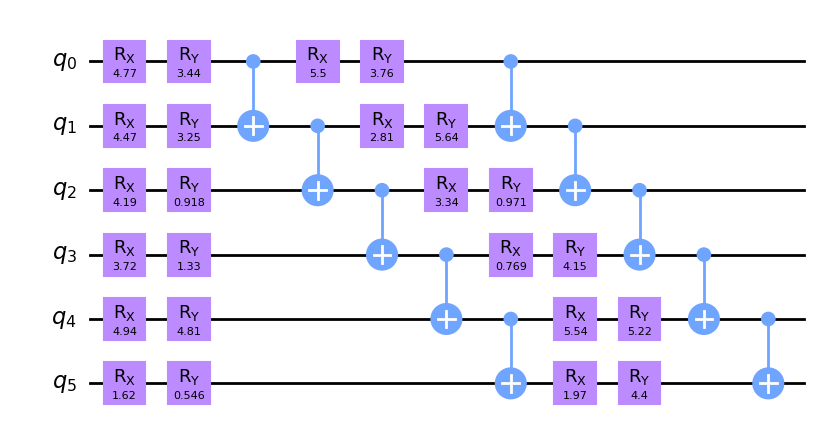

In [18]:
size = 6
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

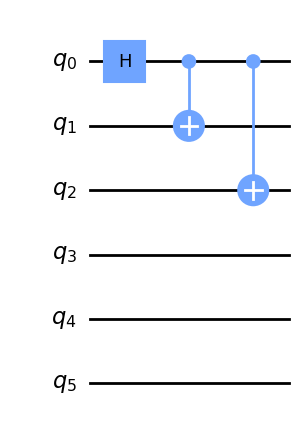

In [45]:
qcTest = QuantumCircuit(6)
#qcTest.ry(2*np.arccos(1/np.sqrt(3)), 0)
#qcTest.append(CHGate(), [0, 1])
#qcTest.cx(1, 2)
#qcTest.cx(0, 1)
#qcTest.x(0)

#qcTest.x(0)
#qcTest.x(1)
#qcTest.append(CHGate(), [1, 2])
#qcTest.ccx(0, 2, 1)

qcTest.h(0)
qcTest.cx(0, 1)
qcTest.cx(0, 2)

qcTest.draw('mpl')

In [46]:
psi = np.array(DensityMatrix.from_instruction(qcTest.reverse_bits()))
rho = pt(psi, [4, 5, 6], [2, 2, 2, 2, 2, 2])
print(rho)

[[0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j]]


In [47]:
U1_1qubit = np.array([[1, 0], [0, 1j]], dtype=complex)
U1 = np.kron(np.kron(U1_1qubit, U1_1qubit), U1_1qubit)
U2 = np.matmul(U1, U1)
U3 = np.matmul(U2, U1)

In [48]:
shape = rho.shape

X = cp.Variable(shape, complex=True)
sig = cp.Variable(shape, complex=True)
G = cp.bmat([[rho, X.H],[X, sig]])

c = [sig>>0, G>>0, cp.real(cp.trace(sig))==1]

#Add the constraints that make sig G-symmetric
c.append(U1@sig == sig@U1)
c.append(U2@sig == sig@U2)
c.append(U3@sig == sig@U3)

obj = cp.Maximize(0.5*(cp.real(cp.trace(X)) + cp.real(cp.trace(X.H))))
problem = cp.Problem(obj, constraints = c)
rootFid = problem.solve()
print("Root Fidelity is : " + str(rootFid))

WARN: A->p (column pointers) not strictly increasing, column 128 empty
WARN: A->p (column pointers) not strictly increasing, column 137 empty
WARN: A->p (column pointers) not strictly increasing, column 146 empty
WARN: A->p (column pointers) not strictly increasing, column 155 empty
WARN: A->p (column pointers) not strictly increasing, column 164 empty
WARN: A->p (column pointers) not strictly increasing, column 173 empty
WARN: A->p (column pointers) not strictly increasing, column 182 empty
WARN: A->p (column pointers) not strictly increasing, column 191 empty
Root Fidelity is : 0.707360757681732


In [49]:
print("Fidelity is : " + str(rootFid**2))

Fidelity is : 0.500359241508074
